## Imports

In [199]:
import os
import sys
from torch import nn
import random
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    Batch
    )
from torch_geometric.data.storage import EdgeStorage
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

seed = 1234
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

1.10.1+cu102
10.2
3.6.9


## Dataset creation

### Graph file locations

In [141]:
folders = ["/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_automated/PreparedStatement.executeQuery/*.txt", 
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_automated/Calendar.getTime/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_automated/URL.openConnection/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_automated/BufferedReader.readLine/*.txt"]

### Method to process raw graph data(in .txt format)

In [142]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:
    
    file_name = inTextFile.split("/")[-2].strip() + " - " + inTextFile.split("/")[-1].strip()

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
      N[0], N[1] = N[0].strip(), N[1].strip()
      
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name

In [143]:
file = "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_automated/URL.openConnection/4_878_graph_dump.txt"

get_nodes_edges(file, add_reverse_edges = False)

({'Line_4 $$ URLConnection connection = url.openConnection()': 0,
  'Line_5 $$ connection.connect()': 1,
  'Line_6 $$ return connection.getLastModified();': 2,
  'Line_3 $$ public void readDTM(URL url)': 3},
 [[0, 1], [0, 2]],
 [[3, 0], [3, 1], [3, 2]],
 [[0, 1], [0, 2], [3, 0], [3, 1], [3, 2]],
 [0, 0, 1, 1, 1],
 'URL.openConnection - 4_878_graph_dump.txt')

### Method to get CodeBERT embedding for nodes

In [144]:
from transformers import AutoTokenizer, AutoModel
import torch

#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
#model.to(device)

In [145]:
def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens=tokenizer.tokenize(code_line)
        tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
        tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings=model(torch.tensor(tokens_ids)[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

### Method to create data objects for GNN

In [ ]:
import glob
import tqdm
import sys

dataset =[]
for label, folder in tqdm.tqdm(enumerate(folders)):
  print("\nProcessing: {}\n".format(folder))
  files = glob.glob(folder)
  print("\nNumber of files: {}\n".format(len(files)))
  count = 0
  for file in files:

    if(count % 10 == 0):
          print("\nAt file: {}\n".format(count))
    nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type, file_name = get_nodes_edges(file, add_reverse_edges = True)
    if(len(nodes_dict) == 0):
      print("No Data: ", file)
      continue
    #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

    # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
    try:
      CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
    except Exception as e :
      print("Error: ", e)
      print(nodes_dict)
      sys.exit()
    #print(CodeEmbedding.shape)

    # FIXING DATA FOTMATS AND SHAPE
    x = torch.tensor(CodeEmbedding)
    # print(x.shape)
  
    # data.y: Target to train against (may have arbitrary shape),
    # graph-level targets of shape [1, *]
    y = torch.tensor([label], dtype=torch.long)
    #print(type(y))

    # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
    edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
    edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
    #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
    data = Data(edge_index=edge_index, edge_type=edge_type, x=x)
    data.y = y
    data.num_nodes = len(nodes_dict)
    data.api = file_name
    dataset.append(data)
    count += 1

print("\nLength of the dataset: ", len(dataset))

### Save the dataset as CSV

In [180]:
import pandas as pd
import numpy as np

dict = {"x" : [], "edge_index" : [], "edge_type" : [], "y" : [], "num_nodes" : [], "api_file_name": []}
for data in dataset:
    dict["x"].append(np.array(data.x, dtype = np.float32))
    dict["edge_index"].append(np.array(data.edge_index, dtype = np.int64))
    dict["edge_type"].append(np.array(data.edge_type, dtype = np.int64))
    dict["y"].append(np.array(data.y, dtype = np.int64))
    dict["num_nodes"].append(data.num_nodes)
    dict["api_file_name"].append(data.api)
    
df = pd.DataFrame(data = dict)
print(dict["x"][0].dtype, dict["edge_index"][0].dtype, dict["edge_type"][0].dtype, dict["y"][0].dtype)
print(df.dtypes)
print("\nShape of dataframe: ", df.shape)
df.to_csv('/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/Initial embedding/dataset-4.csv')

# np_data = np.asarray([np.asarray(dict["x"]),
#                       np.asarray(dict["edge_type"]), 
#                       np.asarray(dict["y"]), 
#                       np.asarray(dict["num_nodes"]), 
#                       np.asarray(dict["api_file_name"])])
# np.savetxt('/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/Initial embedding/np-dataset-1.csv', np_data, delimiter=",")

float32 int64 int64 int64
x                object
edge_index       object
edge_type        object
y                object
num_nodes         int64
api_file_name    object
dtype: object

Shape of dataframe:  (2558, 6)


### Load data from existing file 

In [160]:
import pandas as pd

graphs_file_path = "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/Initial embedding/dataset-4.csv"
df = pd.read_csv(graphs_file_path)
print("\nShape of dataframe: ", df.shape)
temp_dataset = []
for ind in df.index:
    temp = np.array(df['edge_index'][ind])
    data = Data(edge_index = torch.tensor(np.array(df['edge_index'][ind]), dtype=torch.int64), 
                edge_type = torch.tensor(np.array(df['edge_type'][ind]), dtype=torch.int64), 
                x = torch.tensor(np.array(df['x'][ind]), dtype=torch.float32))
    data.y = torch.from_numpy(np.array(df['y'][ind]), dtype=torch.int64)
    data.num_nodes = int(df['num_nodes'][ind])
    data.api = df['api_file_name'][ind]
    temp_dataset.append(data)
print("\nLength of the dataset: ", len(temp_dataset))


Shape of dataframe:  (2558, 7)
<class 'str'>

Length of the dataset:  0


### Filter the datapoints if needed

In [194]:
print("\nLength of the dataset: ", len(dataset))
filtered_dataset = []
for data in dataset:
    if data.num_nodes >=3 :
        filtered_dataset.append(data)
        
print("\nLength of the filtered dataset: ", len(filtered_dataset))


Length of the dataset:  2558

Length of the filtered dataset:  1857


### Graph Statistics & Visualization

In [196]:
print("\nLength of the dataset: ", len(filtered_dataset))

data = filtered_dataset[0]
print(data, "\n")
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_type)
#print(data.x.dtype, data.edge_index.dtype, data.edge_type.dtype, data.y.dtype)


Length of the dataset:  1857
Data(x=[3, 768], edge_index=[2, 6], edge_type=[6], y=[1], num_nodes=3, api='PreparedStatement.executeQuery - 22_776_graph_dump.txt') 

Number of nodes: 3
Number of edges: 6
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[0, 1, 2, 1, 0, 2],
        [1, 0, 1, 2, 2, 0]])
tensor([1, 1, 0, 0, 1, 1])


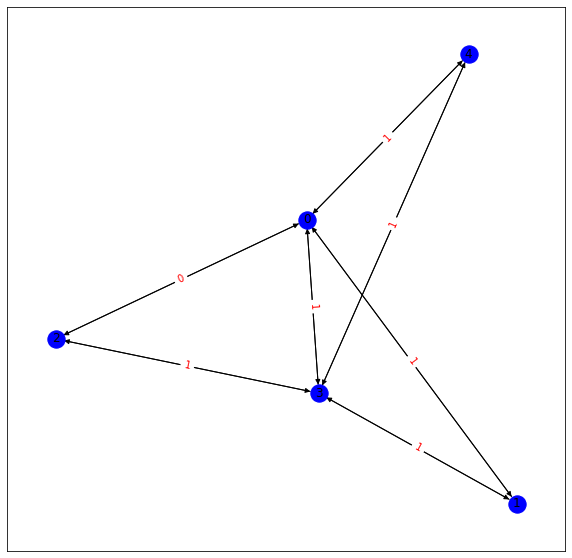

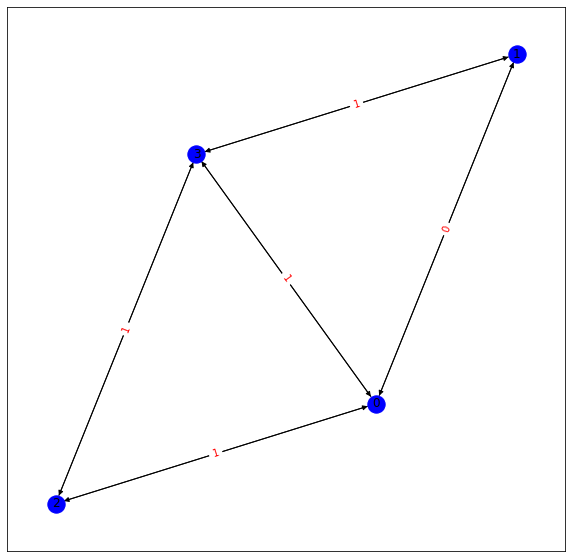

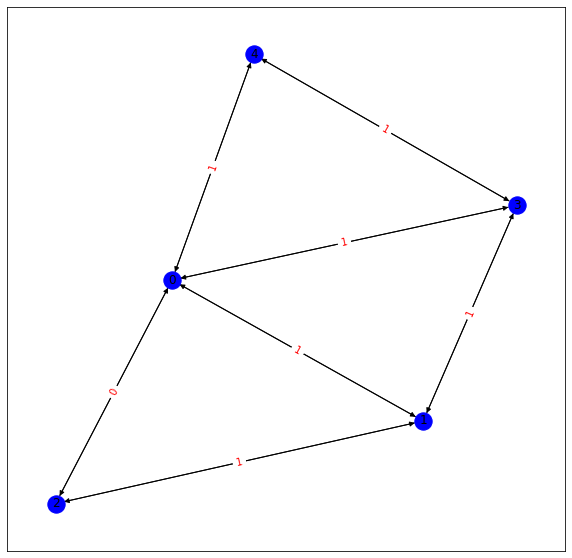

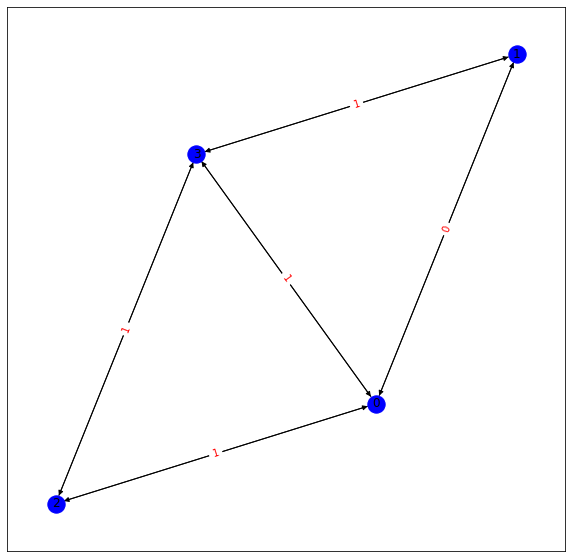

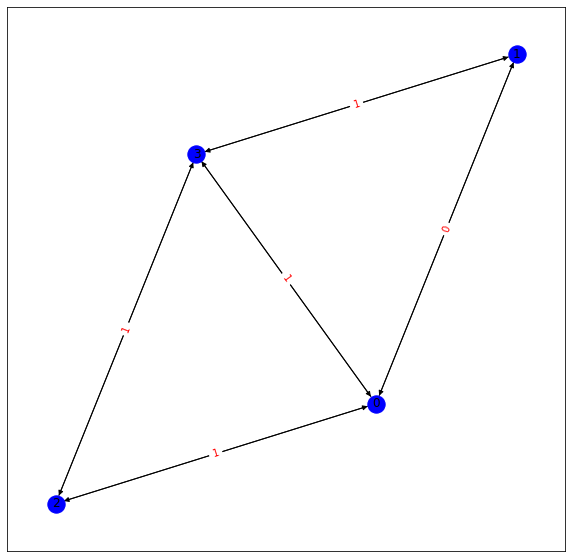

In [197]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = {}
    for i in range(len(G.edges)):
        edge = list(G.edges)[i]
        edge_labels[edge[0], edge[1]] = int(data.edge_type[i])
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

for G in filtered_dataset[25:30]:
    visualize_graph(G, color="blue")

### Create train and test splits

In [198]:
import random
random.seed(1234)

shuffled_dataset = random.sample(filtered_dataset, len(filtered_dataset))

train_dataset = shuffled_dataset[:int(len(filtered_dataset) * 0.95)]
test_dataset = shuffled_dataset[int(len(filtered_dataset) * 0.95):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1764
Number of test graphs: 93


### Create the dataloaders

In [200]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

## Model

### Define the model

In [201]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4):
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Visualizing the embeddings

In [202]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def visualize_embeddings(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

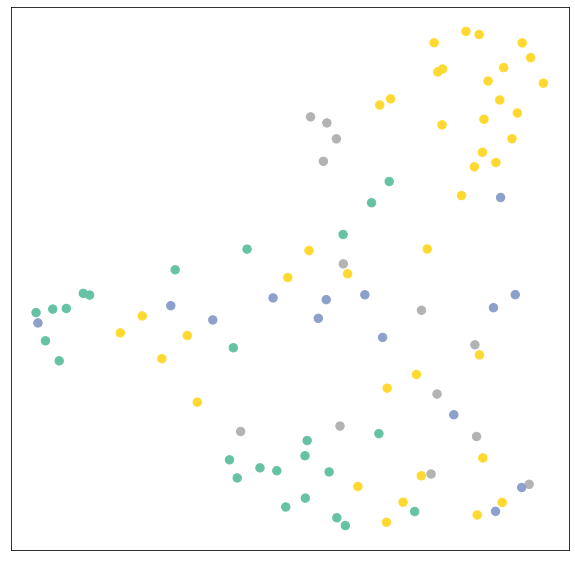

In [203]:
model = GCN(hidden_channels=64)

model.eval()
dataloader = DataLoader(test_dataset, len(test_dataset), shuffle=False)
for data in dataloader:
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

### Training & Testing

In [207]:
os.environ["CUDA_VISIBLE_DEVICES"] = "12,9"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count(), torch.cuda.current_device())

cuda 16 0


In [210]:
model = GCN(hidden_channels=64)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         data.to(device)
         out, _ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print("Out = {} and Label = {}".format(out, data.y))
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += float(loss)
    print("Loss: ", total_loss)

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data.to(device)
         out, _ = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(0, 10):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Loss:  129.20050126314163
Epoch: 000, Train Acc: 0.5471, Test Acc: 0.5591
Loss:  78.94218657910824
Epoch: 001, Train Acc: 0.6474, Test Acc: 0.5806
Loss:  74.03692951798439
Epoch: 002, Train Acc: 0.6026, Test Acc: 0.6667
Loss:  70.47710156140965
Epoch: 003, Train Acc: 0.6536, Test Acc: 0.5806
Loss:  62.18152819573879
Epoch: 004, Train Acc: 0.7732, Test Acc: 0.6667
Loss:  52.04059587419033
Epoch: 005, Train Acc: 0.8107, Test Acc: 0.6989
Loss:  53.1145374327898
Epoch: 006, Train Acc: 0.8141, Test Acc: 0.6882
Loss:  52.6261947453022
Epoch: 007, Train Acc: 0.6440, Test Acc: 0.6667
Loss:  56.27340270578861
Epoch: 008, Train Acc: 0.7778, Test Acc: 0.6559
Loss:  44.57420741021633
Epoch: 009, Train Acc: 0.8090, Test Acc: 0.6774


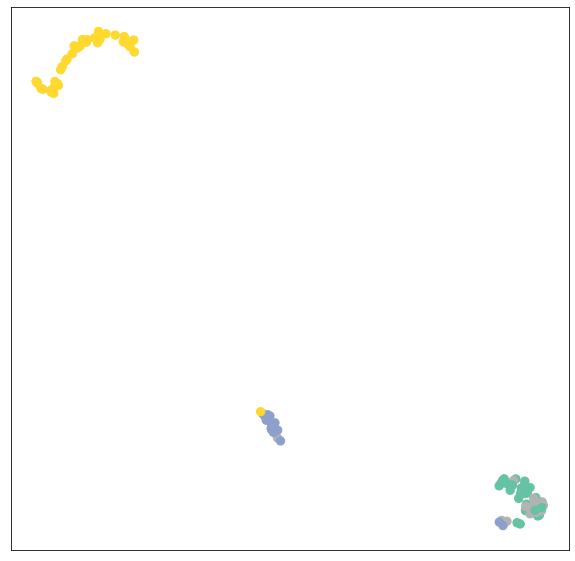

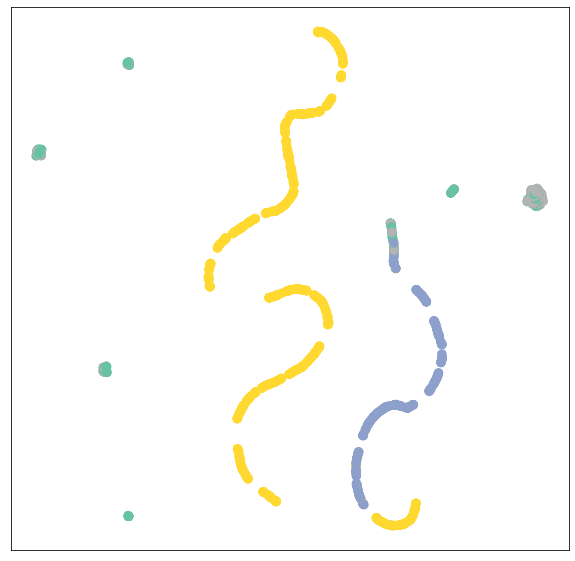

In [234]:
model.to(torch.device("cpu"))
for data in DataLoader(test_dataset, len(test_dataset), shuffle=False):
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)
    
for data in DataLoader(train_dataset, len(train_dataset), shuffle=False):
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

## Cluster the embeddings

### Collect embeddings for a specific class or API

In [237]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

CLASS_LABEL = 2

model.eval()
train_api_embeddings, train_api_datapoints = [], []
test_api_embeddings, test_api_datapoints = [], []

for data in DataLoader(test_dataset, len(test_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.batch)
    for i in range(len(test_dataset)):
        if(int(data[i].y) == CLASS_LABEL):
            test_api_datapoints.append(data[i])
            test_api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(test_api_embeddings), len(test_api_datapoints))

for data in DataLoader(train_dataset, len(train_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.batch)
    for i in range(len(train_dataset)):
        if(int(data[i].y) == CLASS_LABEL):
            train_api_datapoints.append(data[i])
            train_api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(train_api_embeddings), len(train_api_datapoints))

40 40
857 857


### K-Means

#### Get optimal clusters number

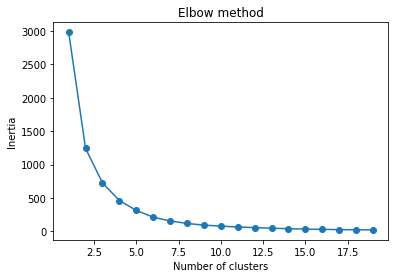

In [248]:
inertias = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(train_api_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Do clustering

In [250]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(train_api_embeddings)
test_api_clusters = kmeans.predict(test_api_embeddings)
print(test_api_clusters)

[0 3 1 1 0 2 1 1 0 3 1 1 1 2 1 2 2 1 2 1 0 1 1 0 1 2 1 0 0 3 0 1 1 4 2 3 1
 3 2 2]


#### Visualize using t-SNE 

In [281]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objs as go
import chart_studio.plotly as py

tsne_output_2d = TSNE(n_components = 2).fit_transform(train_api_embeddings)
tsne_dataframe_2d = pd.DataFrame(tsne_output_2d)
tsne_dataframe_2d['cluster'] = kmeans.predict(train_api_embeddings)
tsne_dataframe_2d.columns = ['x1','x2','cluster']

tsne_output_3d = TSNE(n_components = 3).fit_transform(train_api_embeddings)
tsne_dataframe_3d = pd.DataFrame(tsne_output_3d)
tsne_dataframe_3d['cluster'] = kmeans.predict(train_api_embeddings)
tsne_dataframe_3d.columns = ['x1','x2', 'x3', 'cluster']

fig = px.scatter(
    tsne_dataframe_2d[["x1", "x2"]], x="x1", y="x2",
    color=tsne_dataframe_2d["cluster"], labels={'color': 'clusters'}
)
fig.show()

fig = px.scatter_3d(
    tsne_dataframe_3d[["x1", "x2", "x3"]], x="x1", y="x2", z="x3",
    color=tsne_dataframe_3d["cluster"], labels={'color': 'clusters'}
)
fig.update_traces(marker_size = 8)
fig.show()

#### Visualize using UMAP

In [282]:
from umap import UMAP
import plotly.express as px

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_output_2d = umap_2d.fit_transform(train_api_embeddings)
umap_dataframe_2d = pd.DataFrame(umap_output_2d)
umap_dataframe_2d['cluster'] = kmeans.predict(train_api_embeddings)
umap_dataframe_2d.columns = ['x1','x2', 'cluster']

umap_3d = UMAP(n_components=3, init='random', random_state=0)
umap_output_3d = umap_3d.fit_transform(train_api_embeddings)
umap_dataframe_3d = pd.DataFrame(umap_output_3d)
umap_dataframe_3d['cluster'] = kmeans.predict(train_api_embeddings)
umap_dataframe_3d.columns = ['x1','x2', 'x3', 'cluster']

fig_2d = px.scatter(
    umap_dataframe_2d[["x1", "x2"]], x="x1", y="x2",
    color=umap_dataframe_2d["cluster"], labels={'color': 'clusters'}
)
fig_3d = px.scatter_3d(
    umap_dataframe_3d[["x1", "x2", "x3"]], x="x1", y="x2", z="x3",
    color=umap_dataframe_3d["cluster"], labels={'color': 'clusters'}
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

### BIRCH Clustering

### DBSCAN Clustering